# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv.
- /datasets/geo_data_2.csv.

Столбцы:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (**тыс. баррелей**).


## Загрузка и подготовка данных

Выгружаем необходимые библиотеки и методы из них, а также заблочим варнинги, так как они меня пугают(O-o):

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

Выгрузим датасеты в переменные и изучим их содержимое:

In [ ]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [ ]:
df1.info()
df1.describe()
df1.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

In [ ]:
df2.info()
df2.describe()
df2.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

In [ ]:
df3.info()
df3.describe()
df3.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


0

Первая практическая без пропусков и вопросов, чем же их заполнить, слезы счастья так и наворачиваются... Объем в скважинах везде положителен, что тоже радует, ну и три признака, которые настолько важны, что мы без понятия, что же они означают, но вроде не слишком отличны друг от друга, по крайней мере так кажется на первый взгляд. Проверим корелляцию значений.

In [ ]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [ ]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


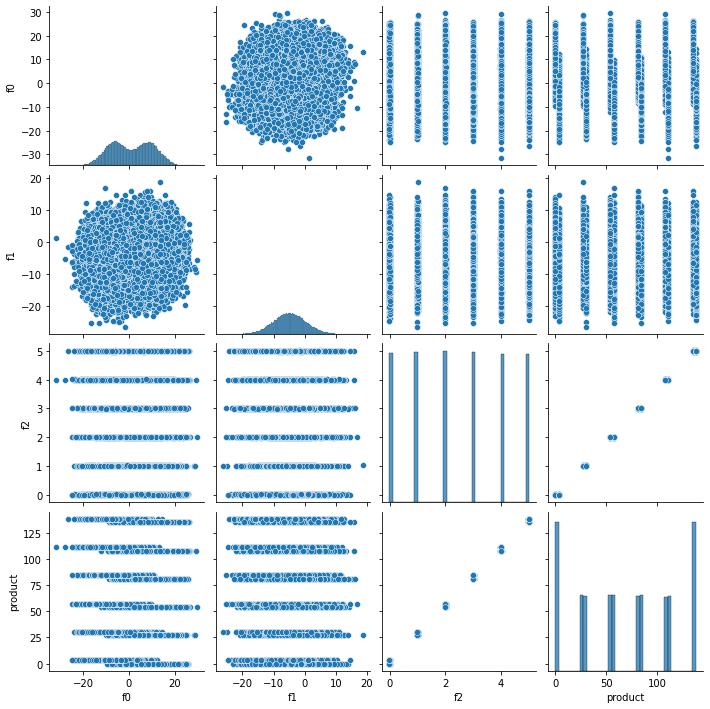

In [ ]:
sns.pairplot(df2)

In [ ]:
df3.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


**Выводы**
- product - целевой признак
- Не особая информативная предобработка, f0, f1, f2 - это признаки, но что они значат пока неизвестно. Однако они точно влияют на целевой признак, иначе их бы тут не было!
- Айдишники для обучения не имеют никакого смысла, скорее всего выкинем их в следующей главе
- Какая-то сказочная корреляция во втором регионе с количеством нефтепродукта! По графику видна прямая линейность, они явно связаны, да еще как!

## Обучение и проверка модели

Разобьем каждый датасет на обучающую и валидационную выборку

In [ ]:
k=1

for data in [df1,df2,df3]:
    target = data['product']
    features = data.drop(['product', 'id'], axis=1) # выкинем айдишники, они не несут смысловой нагрузки для обучения

    # Разбивка данных для обучения и валидации
    features_train, features_valid, target_train,target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train) # Обучение
    predicted_valid = model.predict(features_valid) # Предсказания
    rmse = mean_squared_error(target_valid, predicted_valid)**0.5
    predicted_valid_mean = predicted_valid.sum()/len(predicted_valid)
    print ('Регион '+ str(k) + ' в среднем имеет '+ str(predicted_valid_mean) +' тыс. баррелей нефти а также среднюю квадратичную ошибку равную ' + str(rmse))
    k+=1

Регион 1 в среднем имеет 92.59256778438035 тыс. баррелей нефти а также среднюю квадратичную ошибку равную 37.5794217150813
Регион 2 в среднем имеет 68.728546895446 тыс. баррелей нефти а также среднюю квадратичную ошибку равную 0.893099286775617
Регион 3 в среднем имеет 94.96504596800489 тыс. баррелей нефти а также среднюю квадратичную ошибку равную 40.02970873393434


Код, конечно, тот еще колхозджан, но что смогли, то и исполнили, надо придумать как рациональнее сохранить предикты, закидывать в массив - идея плохая, и почему то в нем оказываются 25к записей, вместо 30к(((

Первый и третий регионы похожи, сырья там много, но разбросы большие. А второй же менее сырьевой, однако вме распределенно равномерно. Посмотрим на его дисплот-график. distplot одновременно показывает гистограмму и график плотности распределения.

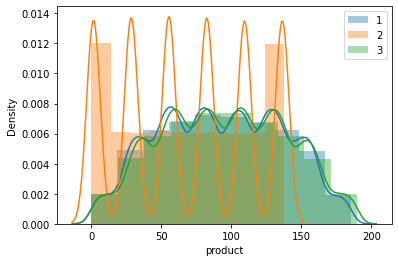

In [ ]:
for i, df in enumerate([df1,df2,df3]): # шикарно-модно-хайповый график, который я бесцеремонно украл у кого-то
    sns.distplot(df['product'], label = i+1, bins=10)
    plt.legend()

Действительно, первый и третий регион братья близнецы, а второй не от мира сего :)

**Вывод**
- Разделили выборки, обучили модель, жизнь прекрасна
- Выяснили, что второй регион отличается от двух других по распределнию нефти.

## Подготовка к расчёту прибыли

Запишем необходимые константы

In [ ]:
BUDGET = 10000000
CP = 500
BEST = 200
PPB = 450

Посмотрим средний запас нефти в регионах:

In [ ]:
for data in [df1,df2,df3]:
    print(data['product'].mean())

92.50000000000001
68.82500000000002
95.00000000000004


Объем нефти указан в тысячах барраллей, поэтому чтобы упростить взаимодействие с рублем, домножать в дальнейшем на тысячу. Найдем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки

In [ ]:
na_1=(BUDGET/BEST)
print('Бюджет на разработку одну скважину:', na_1/1000,'миллионов рублей')

Бюджет на разработку одну скважину: 50.0 миллионов рублей


Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [ ]:
value=na_1/PPB
print('Объём каждой скважины для безубыточной разработки должен составлять не менее:', value,'баррелей')

Объём каждой скважины для безубыточной разработки должен составлять не менее: 111.11111111111111 баррелей


**Сравним необходимый для безубыточной разратки с нашим**.
Для начала добавим столбцы с прибылью

In [ ]:
for data in [df1,df2,df3]:
    data['money'] = data['product']*PPB
    print(data['money'].mean())

41625.00000000001
30971.25
42750.000000000015


Теперь воспользуемся формулой ROI - коэффициенту возврату инвестиций (ROI = (доход – затраты) / затраты × 100 %). Если показатели будут отрицательные, это будет очень грустно с точки зрения окупаемости.

In [ ]:
i = 1
for data in [df1,df2,df3]:
    data['roi']=(data['money']-na_1)/na_1*100
    print('Значение среднее значение параметра ROI в',i,'регионе равен',data['roi'].mean())
    i+=1

Значение среднее значение параметра ROI в 1 регионе равен -16.749999999999986
Значение среднее значение параметра ROI в 2 регионе равен -38.05749999999999
Значение среднее значение параметра ROI в 3 регионе равен -14.499999999999984


**Вывод**

Анализируя среднее по параметру ROI, можно сказать, что мы скорее всего потратим свои инвестиции, в пустоту, если будем выбирать на бум. Необходимо отобрать лучшие, и тогда, надеюсь, что-то изменится

**Напишем функцию расчёта прибыли**

In [ ]:
def total_money(data,BEST):
    target = data['product']
    features = data.drop(['product', 'id','roi','money'], axis=1) # выкинем айдишники, они не несут смысловой нагрузки для обучения
    features_train, features_valid, target_train,target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train) # Обучение
    predicted_valid = model.predict(features_valid) # Предсказания

    predicted_sorted = pd.Series(predicted_valid, index=target_valid.index).sort_values(ascending=False)
    sum_200 = predicted_sorted[:BEST].sum()
    total_income=sum_200*PPB-BUDGET

    print('200 лучших скважин дают',sum_200,'тыс.баррелей')
    print('Прибыль для полученного объёма равна', total_income/1000, 'миллионов рублей')
    print('Средний объем тысяч баррелей на скважину равен', sum_200/200)

In [ ]:
k=1
for i in [df1,df2,df3]:
    print('Для', k, 'региона')
    total_money(i,BEST)
    k+=1
    print('------------------------------------------------------------------')

Для 1 региона
200 лучших скважин дают 31102.3308388114 тыс.баррелей
Прибыль для полученного объёма равна 3996.048877465129 миллионов рублей
Средний объем тысяч баррелей на скважину равен 155.511654194057
------------------------------------------------------------------
Для 2 региона
200 лучших скважин дают 27746.026782163426 тыс.баррелей
Прибыль для полученного объёма равна 2485.712051973542 миллионов рублей
Средний объем тысяч баррелей на скважину равен 138.73013391081713
------------------------------------------------------------------
Для 3 региона
200 лучших скважин дают 29603.898658318347 тыс.баррелей
Прибыль для полученного объёма равна 3321.7543962432555 миллионов рублей
Средний объем тысяч баррелей на скважину равен 148.01949329159174
------------------------------------------------------------------


Перед началом последнего блока, сохраню все таргет вэлиды и предикты отдельно, ибо весь проект я жалею, что не сделал так с начала, везде приходится вновь обучать(

In [ ]:
def education(data):
    target = data['product']
    features = data.drop(['product', 'id','roi','money'], axis=1) # выкинем айдишники, они не несут смысловой нагрузки для обучения
    features_train, features_valid, target_train,target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(features_train, target_train) # Обучение
    predicted_valid = model.predict(features_valid) # Предсказания
    return target_valid.reset_index(drop=True), pd.Series(predicted_valid)
target1, pred1 = education(df1)
target2, pred2 = education(df2)
target3, pred3 = education(df3)

**Вывод**

По итогу имеем, что все регионы, при выборе лучших скважен проходят достаточный объём сырья для безубыточной разработки новой скважины.

## Расчёт прибыли и рисков

In [ ]:
random = np.random.RandomState(12345)
def profit(target, pred, count): # другая форма подсчета прибыли без обучения
    pred_sorted = pred.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return 450 * selected.sum() - 10000000

def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=random)
        pred_subsample = predictions[target_subsample.index]
        values.append(profit(target_subsample, pred_subsample, 200))
    risk = 0.025
    values = pd.Series(values)
    lower = values.quantile(risk)
    high = values.quantile(0.975)
    interval = (lower, high)
    mean = values.mean()
    # print(values)
    print('Средняя прибыль:' , (mean / 100000), 'млрд.рублей')
    print('2,5%-квантиль:',(mean / 100000),'млрд.рублей')
    print('97,5%-квантиль:', high,'млрд.рублей')
    print('Доверительный интервал: ', interval)
    print('Риск', (values < 0).mean()*100,'%')

In [ ]:
print('Данные для первого региона:')
bootstrap(target1, pred1)
print('-----------------------------------------------------------------')
print('Данные для второго региона:')
bootstrap(target2, pred2)
print('-----------------------------------------------------------------')
print('Данные для третьего региона:')
bootstrap(target3, pred3)


Данные для первого региона:
Средняя прибыль: 4.259385269105924 млрд.рублей
2,5%-квантиль: 4.259385269105924 млрд.рублей
97,5%-квантиль: 947976.353358369 млрд.рублей
Доверительный интервал:  (-102090.09483793723, 947976.353358369)
Риск 6.0 %
-----------------------------------------------------------------
Данные для второго региона:
Средняя прибыль: 5.182594936973249 млрд.рублей
2,5%-квантиль: 5.182594936973249 млрд.рублей
97,5%-квантиль: 953612.9820669085 млрд.рублей
Доверительный интервал:  (128123.23143308419, 953612.9820669085)
Риск 0.3 %
-----------------------------------------------------------------
Данные для третьего региона:
Средняя прибыль: 4.2019400534405005 млрд.рублей
2,5%-квантиль: 4.2019400534405005 млрд.рублей
97,5%-квантиль: 989629.9398445741 млрд.рублей
Доверительный интервал:  (-115852.60916001163, 989629.9398445741)
Риск 6.2 %


**Вывод**

Бурить скважину нужно во втором, здесь лучшая средняя прибыль и доверительный интервал.

В целом несмотря на малый объем, это была самая слезоточивая для меня работа :C